Authors: Suxuan Zhang, Esther Zhao, Zhiqing Zhang



In [1]:
import pandas as pd
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# (A) Build and train a binary classifier that predicts the label in the first column of Data_A.csv.

In [2]:
df = pd.read_csv('Data_A.csv', header=None)
df = df.to_numpy()

We first observe the data. From the histogram of volume, we can spot that the data is right skewed. In order to cope with the skewness, we can apply the log transform to the volume features. We see that after applying log transformation and standardisation, the values are scaled down and the density plots are symmetric and look like Gaussian distribution.

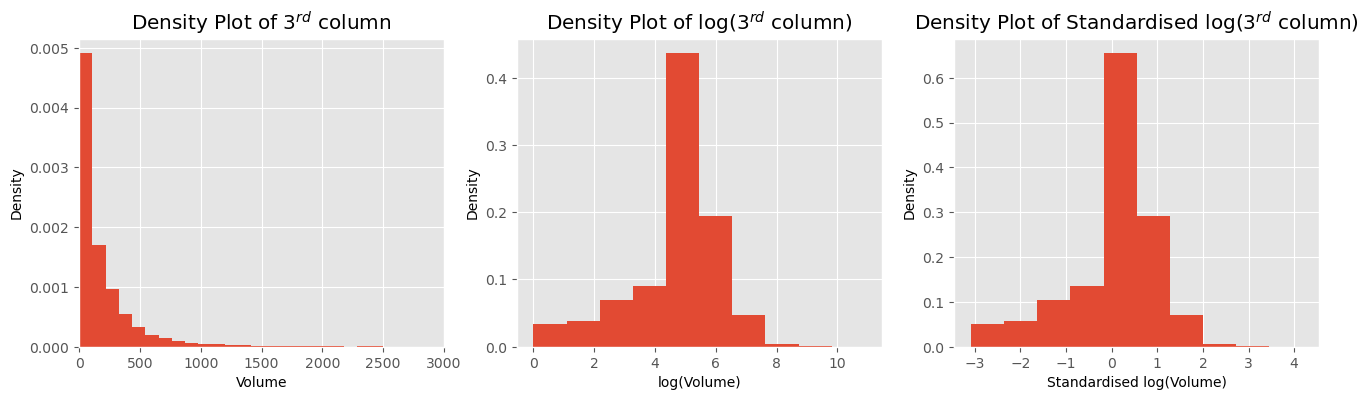

In [3]:
i=2
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.hist(df[:,i],bins=500, density=True)
plt.xlim((0, 3000))
plt.title(r'Density Plot of $3^{rd}$ column')
plt.ylabel('Density')
plt.xlabel('Volume')
plt.subplot(1, 3, 2)
plt.hist(np.log(df[:,i]), density=True)
plt.title(r'Density Plot of log($3^{rd}$ column)')
plt.ylabel('Density')
plt.xlabel('log(Volume)')
plt.subplot(1, 3, 3)
plt.hist((np.log(df[:,i]) - np.log(df[:,i]).mean())/np.log(df[:,i]).std(), density=True)
plt.title(r'Density Plot of Standardised log($3^{rd}$ column)')
plt.ylabel('Density')
plt.xlabel('Standardised log(Volume)')
plt.show();

In [4]:
for i in [2, 4, 6, 8, 10, 12, 14, 16]:
    df[:,i] = np.log(df[:,i])

From the histogram of the price, we can observe that the data appears to have multiple modes. The prices of the two stocks seem to concentrate around several values, which might be a reflection of different expectations of the market.

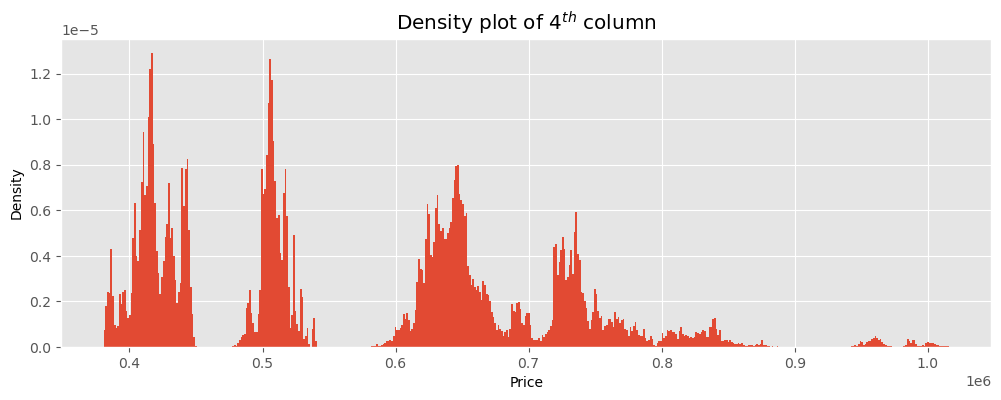

In [5]:
i=3
plt.figure(figsize=(12, 4))
plt.hist(df[:,i],bins=500, density=True)
plt.title(r'Density plot of $4^{th}$ column')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show();

Split the data into training set (80%) and validation set (20%). We train our model on the training set and stop while the increase in accuracy on the validation set becomes insignificant to avoid overfitting. In order to optimise the training, we standardise the features so that they have mean 0 and standard deviation 1.

Note that we will use the mean and standard deviation of training set to standardise the training set, validation set and testing set (dataset B). This is because training set should not use any data from validation set or testing set, so we only use train's mean and std to standardise the training set. For validation and testing set, we should also use train set's mean and variance to keep consistent.

In [6]:
fraction = 0.8
indices = np.random.permutation(len(df))

train_indices = indices[:int(fraction*len(df))]
train_df = df[train_indices]
test_indices = indices[int(fraction*len(df)):]
test_df = df[test_indices]

X_train = train_df[:, 1:]
X_valid = test_df[:, 1:]

# standardisation
X_mean = df[:, 1:].mean(axis=0)
X_std = df[:, 1:].std(axis=0)
# train set should not use any data from validation set, so only use train's mean and std
X_train = (X_train - X_mean) / X_std
# validation set should also use train set's mean and variance to be consistent
X_valid = (X_valid - X_mean) / X_std

Y_train = train_df[:,0]
Y_valid = test_df[:,0]


We build a Feedforward Neural Network (FNN) $f \in \mathcal{N}(21, 64, 32, 1; \mbox{ReLU}, \mbox{Sigmoid})$.



*   Input layer:
The 'input_shape' parameter is set to the number of features in our 'X_train' data set.

*   Hidden Layers: We use ReLU as the activation function because of the low computation cost when calculating gradients by backpropagation. Hence the choice speeds up the training process. After the activation function, we apply the Dropout layer, which operates by randomly drop input units, setting them to 0. We set the rate=0.36 during each hidden training phase. This step effectively introduces randomness into the training process by deactivating input units. Dropout step is beneficial as it reduces the risk of overfitting and encourages a more generalized pattern. Thus, it enables the model to perform well across various datasets.

*   Output Layer: Since we are working with a binary classification problem, we want to have a bounded ouput between 0 and 1. Sigmoid is bounded, differentiable and thus appears to be a reasonable choice.






After careful testing, we pick the learning rate to be 0.0015, batch size to be 250, and epoch number to be 15.

In [7]:
model = Sequential([
    Dense(64, input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.36),
    Dense(32),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.36),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1408      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                       

In [8]:
eta = 0.0015
model.compile(optimizer=keras.optimizers.Adam(learning_rate=eta), loss="binary_crossentropy", metrics=["accuracy"])
history =model.fit(X_train, Y_train, batch_size=250, epochs=15, validation_data=(X_valid, Y_valid))

Epoch 1/15
640/640 [==============================] - 1s 930us/step - loss: 0.6142 - accuracy: 0.6590 - val_loss: 0.5701 - val_accuracy: 0.6976
Epoch 2/15
640/640 [==============================] - 0s 682us/step - loss: 0.5781 - accuracy: 0.6888 - val_loss: 0.5592 - val_accuracy: 0.6992
Epoch 3/15
640/640 [==============================] - 0s 699us/step - loss: 0.5711 - accuracy: 0.6908 - val_loss: 0.5557 - val_accuracy: 0.7022
Epoch 4/15
640/640 [==============================] - 0s 698us/step - loss: 0.5661 - accuracy: 0.6939 - val_loss: 0.5520 - val_accuracy: 0.7041
Epoch 5/15
640/640 [==============================] - 0s 696us/step - loss: 0.5636 - accuracy: 0.6947 - val_loss: 0.5508 - val_accuracy: 0.7060
Epoch 6/15
640/640 [==============================] - 0s 689us/step - loss: 0.5615 - accuracy: 0.6974 - val_loss: 0.5470 - val_accuracy: 0.7079
Epoch 7/15
640/640 [==============================] - 0s 676us/step - loss: 0.5601 - accuracy: 0.6981 - val_loss: 0.5456 - val_accuracy:

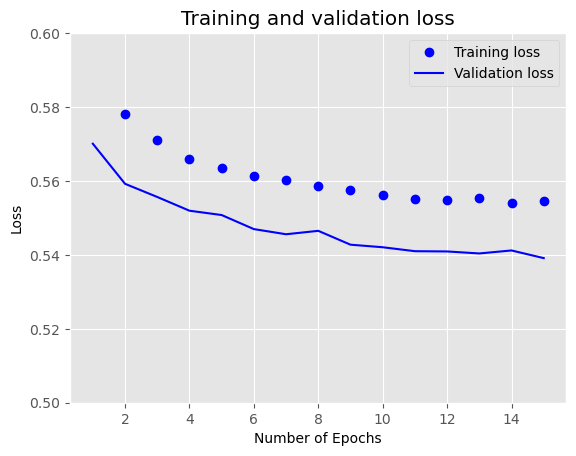

In [9]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.ylim((0.5, 0.6))
plt.legend()
plt.show()

We see that the training loss and validation loss are very close to each other, and the accuracies for both training and validation set are about 71%, which shows the model is relatively good for classification, and it is robust as we do not have overfitting issues.

# (B) Use the binary classifier created in part (A) to predict the labels missing from Data_B_nolabels.csv.

For the testing set, we perform the same data transformation as what we did for training and validation set: we log transform the volume columns, and then standardise the data using mean and standard deviation of the training set.

In [10]:
df_b = pd.read_csv('Data_B_nolabels.csv', header=None)
df_b = df_b.to_numpy()
for i in [2, 4, 6, 8, 10, 12, 14, 16]:
    df_b[:,i-1] = np.log(df_b[:,i-1])
B = (df_b - X_mean) / X_std # standardisation using train set's mean and standard deviation

In [11]:
# output the actual prediction of data B
predictions = model.predict(B)
predicted_labels = (predictions > 0.5).astype(int).flatten()
with open('predicted_labels.txt', 'w') as file:
    for label in predicted_labels:
        file.write(f"{label}\n")

625/625 [==============================] - 0s 238us/step
